In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop

from keras.datasets import cifar10
%matplotlib inline
import matplotlib.pylab as plt 
from tqdm import tnrange
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import activations

In [ ]:
img_rows = 224
img_cols = 224
channel = 3

classes = 2

In [ ]:
depth = 64
dropout = 0.4

In [ ]:
discriminator = Sequential()

input_shape = (img_rows, img_cols, channel)

discriminator.add(Conv2D(depth*1, 5, strides=2, 
                         input_shape=input_shape,padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(classes + 1))
discriminator.add(Activation('softmax'))

#discriminator.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
discriminator_model = Sequential()
discriminator_model.add(discriminator)

discriminator_model.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['accuracy'])

In [ ]:
dropout = 0.4
depth = 64+64+64+64
dim = 56

In [ ]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100 + classes))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(3, 5, padding='same'))
generator.add(Activation('sigmoid'))

#generator.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

adversarial_model = Sequential()
adversarial_model.add(generator)
discriminator.trainable = False
adversarial_model.add(discriminator)

adversarial_model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])
#adversarial_model.summary() 

In [ ]:
'''(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))'''

In [ ]:
'''import numpy as np

data_str=[]
# Create a numpy array from a list of numbers
arr = np.array(y_train)
for i in range(10):
  result = np.where(arr == i)
  print("Elements with value 19 exists at following indices", result[0], sep='\n')
  for j in result[0][0:10]:
    data_str.append([x_train[j],i])

np.save('jahid.npy',data_str)'''

In [ ]:
x_train = np.load('/content/drive/MyDrive/Rice_Test/data1.npy', allow_pickle=True)
y_train = np.load('/content/drive/MyDrive/Rice_Test/Healthy/data1_label.npy', allow_pickle=True)

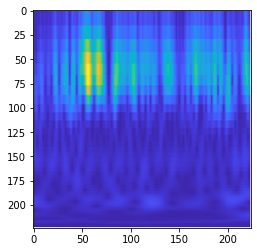

In [ ]:
plt.imshow(x_train[11])

In [ ]:
import numpy as np

In [ ]:
import numpy as np

In [ ]:
training_data.shape

In [ ]:
'''
training_data = np.load('/content/drive/MyDrive/Jahid_data/training_data.npy', allow_pickle=True)[0:20]
x_train1=np.array([i[0] for i in training_data])
y_train1=np.array([i[1] for i in training_data])
'''

In [ ]:
def normalize(images):
    images=images.astype('float32')
    if images.max() > 1.0:
        images/=255.0
    return images

In [ ]:
def one_hot(labels):
    enc = OneHotEncoder()
    return enc.fit_transform(y_train).toarray()

In [ ]:
x_train = normalize(x_train)
#y_train = one_hot(y_train)

In [ ]:
def create_generator_noise(batch_size):
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    sampling = np.random.randint(classes, size=batch_size)
    noise_labels = np.zeros((batch_size, classes))
    noise_labels[np.arange(batch_size), sampling] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input, noise_labels

In [ ]:
def create_generator_noise_by_label(labels):
    noise = np.random.uniform(-1.0, 1.0, size=[len(labels), 100])

    noise_labels = np.zeros((len(labels), classes))
    noise_labels[np.arange(len(labels)), labels] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input

In [ ]:
def train(batch_size=32, train_steps=10000):
    discriminator_losses = []
    adversarial_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
        # Select a random sample from the training data and the labels
        sample_idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        images_train = x_train[sample_idx, :, :, :]
        labels_train = y_train[sample_idx]
        labels_train = np.concatenate((labels_train, np.zeros(shape=(batch_size, 1))), axis=1)
        
        # Create noise in range -1 to 1 and random labels as input for the generator to generate the fake images
        noise_input, _ = create_generator_noise(batch_size)
        images_fake = generator.predict(noise_input)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        labels_fake = np.zeros(shape=(batch_size, classes+1))
        labels_fake[:,-1] = 1
        
        input_data   = np.concatenate((images_train, images_fake))
        input_labels = np.concatenate((labels_train, labels_fake))

        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Train the adversarial model to generate better images
        noise_input, noise_labels = create_generator_noise(batch_size)
        noise_labels = np.concatenate((noise_labels, np.zeros(shape=(batch_size, 1))), axis=1)
        
        adversarial_loss = adversarial_model.train_on_batch(noise_input, noise_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)
        
        if i % 100 == 0:
            labels = [1]
            noise = create_generator_noise_by_label(labels)
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return discriminator_losses, adversarial_losses, sample_images

In [ ]:
discriminator_losses, adversarial_losses, sample_images  = train(train_steps=10000)

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

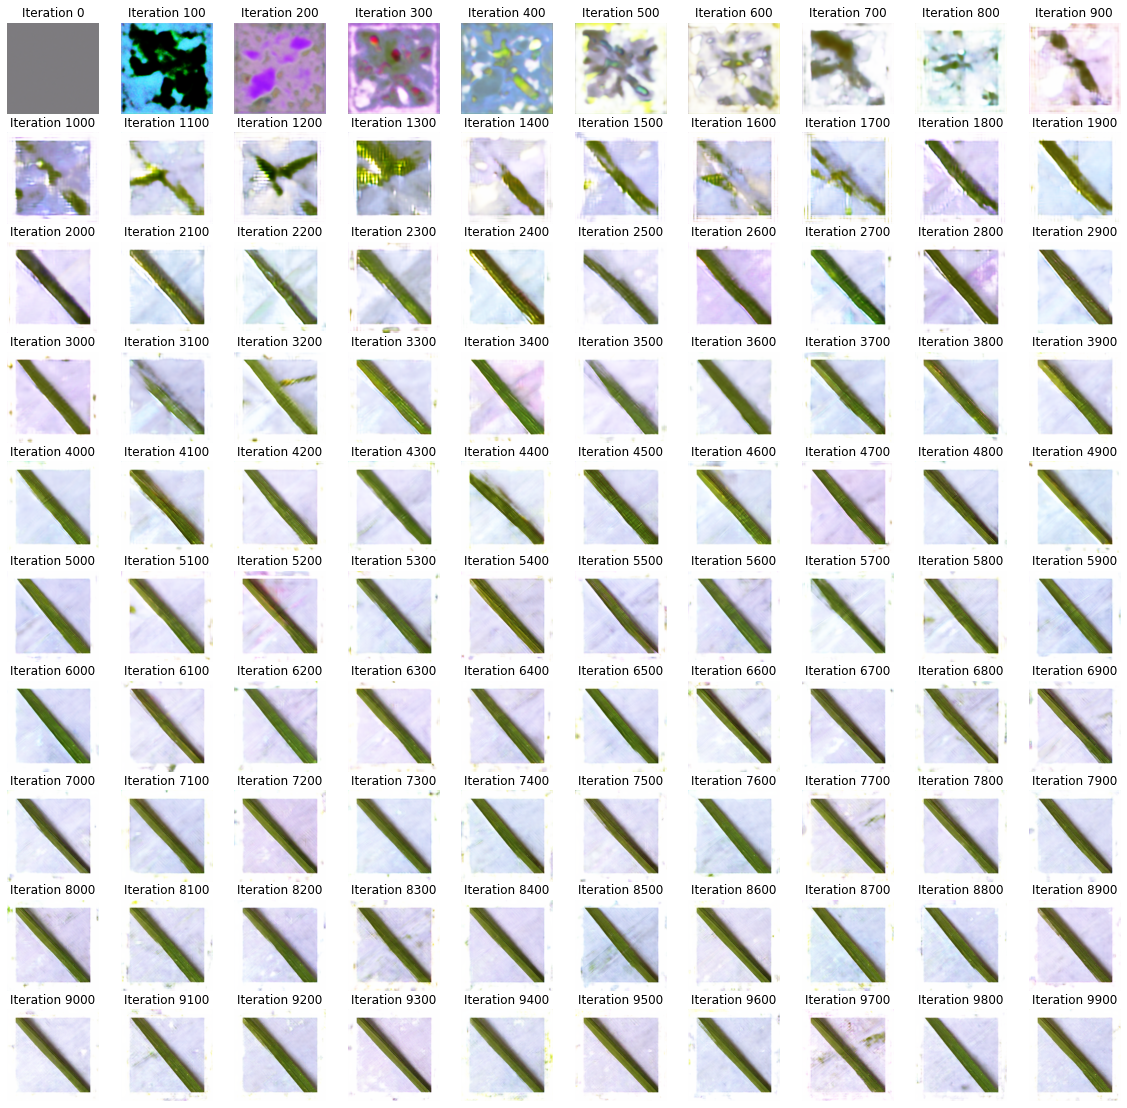

In [ ]:
plt.figure(figsize=(20,40))
for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(20, 10, i+1)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)))
    plt.title("Iteration %d" % (i * 100))
    plt.axis('off')

Text(0.5, 1.0, 'Adveserial Accuracy')

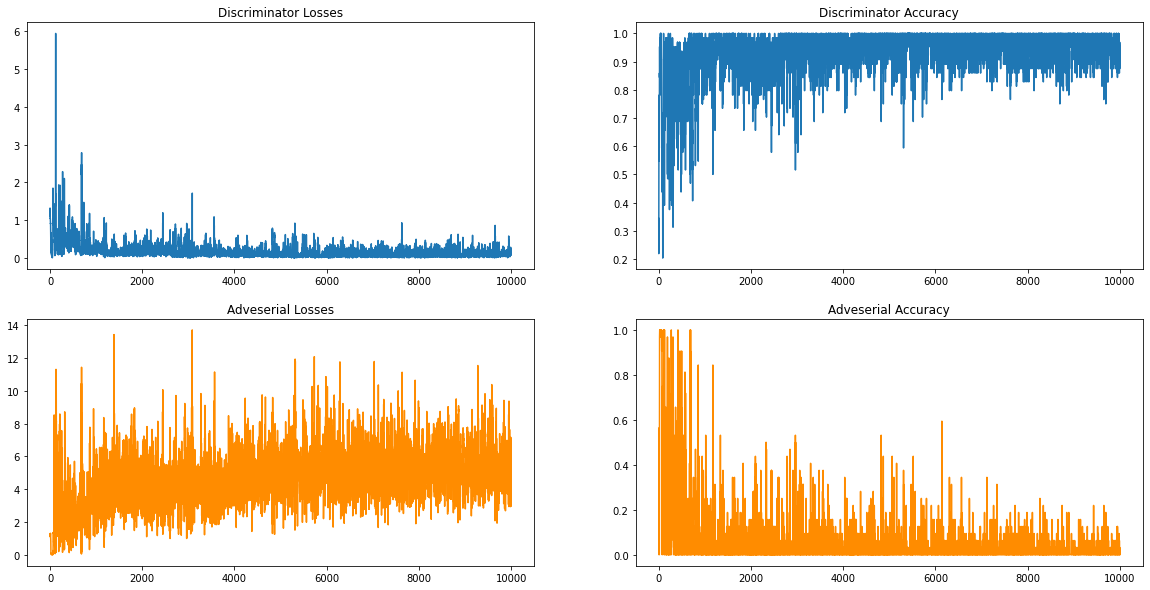

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(discriminator_losses)[:, 0])
plt.title("Discriminator Losses")

plt.subplot(2,2,2)
plt.plot(np.array(discriminator_losses)[:, 1])
plt.title("Discriminator Accuracy")

plt.subplot(2,2,3)
plt.plot(np.array(adversarial_losses)[:, 0], color='darkorange')
plt.title("Adveserial Losses")

plt.subplot(2,2,4)
plt.plot(np.array(adversarial_losses)[:, 1], color='darkorange')
plt.title("Adveserial Accuracy")

In [ ]:
label_names = ["healthy", "Brown_spot"]

In [ ]:
def sample_labels(size):
    labels = []
    for label, _ in enumerate(label_names):
        for sample_size in range(size):
            labels.append(label)
    return labels

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


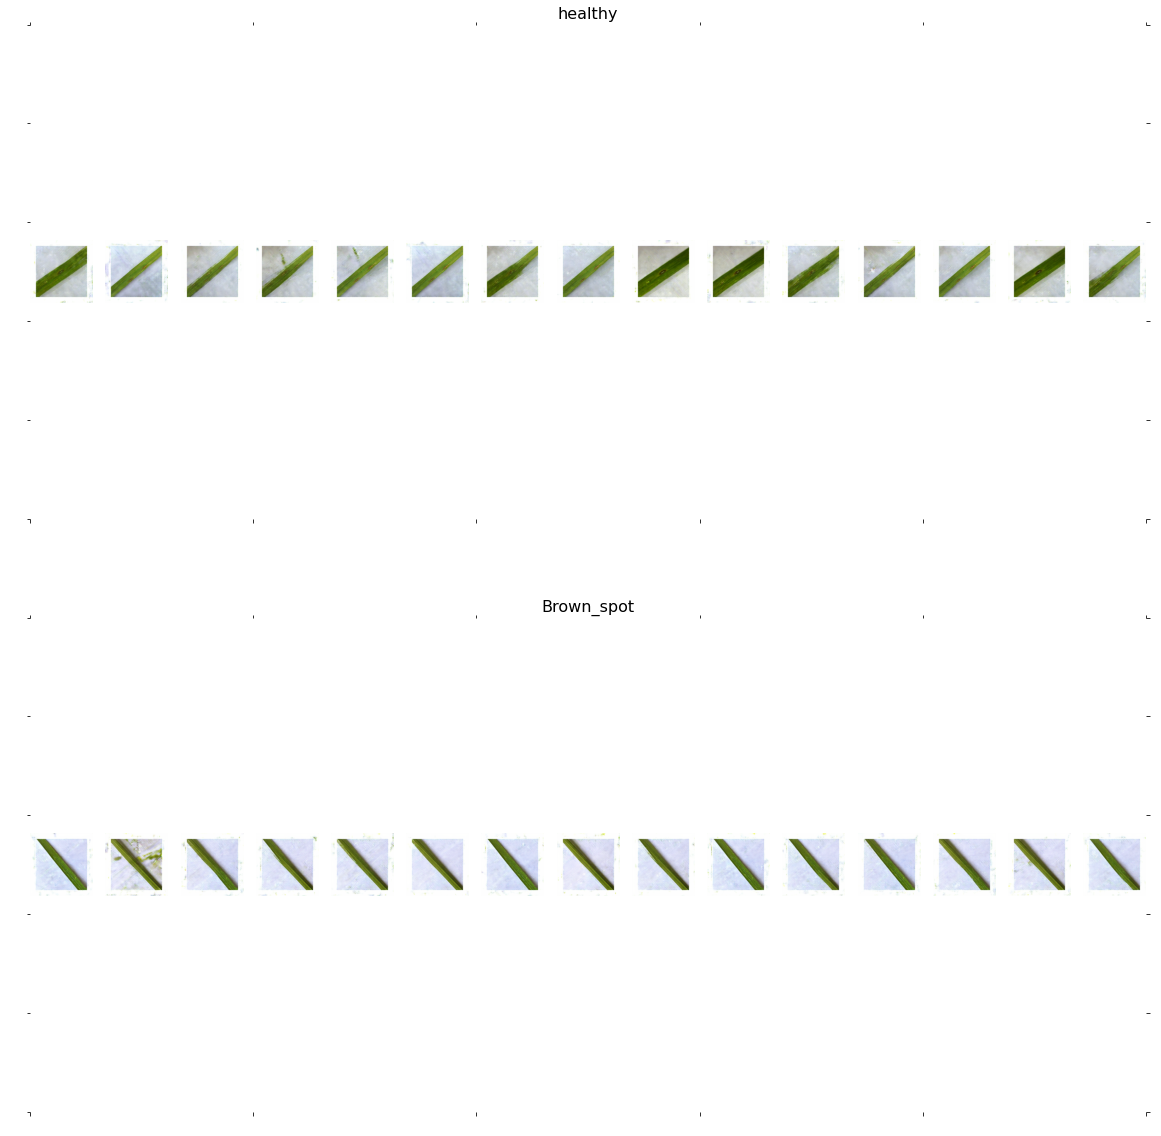

<Figure size 2880x2880 with 0 Axes>

In [ ]:
fig, big_axes = plt.subplots(figsize=(20, 20) , nrows=len(label_names), ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(label_names[row-1], fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

labels = sample_labels(15)
noise = create_generator_noise_by_label(labels)

fake_images = generator.predict(noise)

plt.figure(figsize=(40,40))
for i, fake_image in enumerate(fake_images, 1):
    ax = fig.add_subplot(len(label_names), 15, i)
    ax.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    ax.axis('off')